In [6]:
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit,njit,prange
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm

@jit(nopython=True)
def costh2N(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(lat)*cos(wt) - sin(th_X)*sin(phi_X)*sin(lat)*sin(wt) + costh_X*cos(lat))**2

@jit(nopython=True)
def costh2W(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(wt) - sin(th_X)*sin(phi_X)*cos(wt))**2

@jit(nopython=True)
def costh2Z(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*cos(lat)*cos(wt) + sin(th_X)*sin(phi_X)*cos(lat)*sin(wt) + costh_X*sin(lat))**2

@jit(nopython=True)
def costh2ZW(t,costh_X,phi_X,lat):
    return 1 - costh2N(t,costh_X,phi_X,lat)

@jit(nopython=True)
def costh2ZN(t,costh_X,phi_X,lat):
    return 1 - costh2W(t,costh_X,phi_X,lat)

@jit(nopython=True)
def costh2NW(t,costh_X,phi_X,lat):
    return 1 - costh2Z(t,costh_X,phi_X,lat)


@jit(nopython=True)
def costh_T(fcosth2,lat,DT,T,costh_X,phi_X): 
    ngen = len(costh_X)
    nt = len(T)-1
    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i]+DT,costh_X,phi_X,lat)

    c_av = zeros(shape=(ngen,nt))
    for i in range(0,ngen):
        c_av[i,:] = 0.5*(c1t[i,1:]+c1t[i,0:-1])*(T[1:]-T[0:-1])
        c_av[i,:] = cumsum(c_av[i,:])/T[1:]
    return c_av

def costh_av_Rescan_dist(dTvals,DTvals,fcosth2,lat,ngen=100000):
    
    costh_X = 2*random.uniform(size=ngen)-1.0
    phi_X = 2*pi*random.uniform(size=ngen)


    n1 = len(DTvals)
    n2 = len(dTvals)-1
    c_av0 = costh_T(fcosth2,lat,0,dTvals,costh_X,phi_X)
    C0 = zeros(shape=n2)
    for i in range(0,n2):
        C0[i] = sort(c_av0[:,i])[int(0.05*ngen)]
    
    
    C = zeros(shape=(n1,n2))
    C_enhancement = zeros(shape=(n1,n2))
    for i in tqdm(range(0,n1)):
        c_av1 = costh_T(fcosth2,lat,DTvals[i],dTvals,costh_X,phi_X)
        
        c_av = 0.5*(c_av0+c_av1)
        for j in range(0,n2):
            C[i,j] = sort(c_av[:,j])[int(0.05*ngen)]
            
        C_enhancement[i,:] = C[i,:]/C0
    return C,C_enhancement

n1 = 200
n2 = 200
DTvals = linspace(0.01,1.0,n1)
dTvals = logspace(log10(10/(24*60)),log10(5.0),n2+1)

CN,CN_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2N,55)
CW,CW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2W,35)
CZ,CZ_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2Z,35)

CZW,CZW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2ZW,55)
CZN,CZN_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2ZN,35)
CNW,CNW_enhancement = costh_av_Rescan_dist(dTvals,DTvals,costh2NW,35)

100%|██████████| 200/200 [07:39<00:00,  2.30s/it]


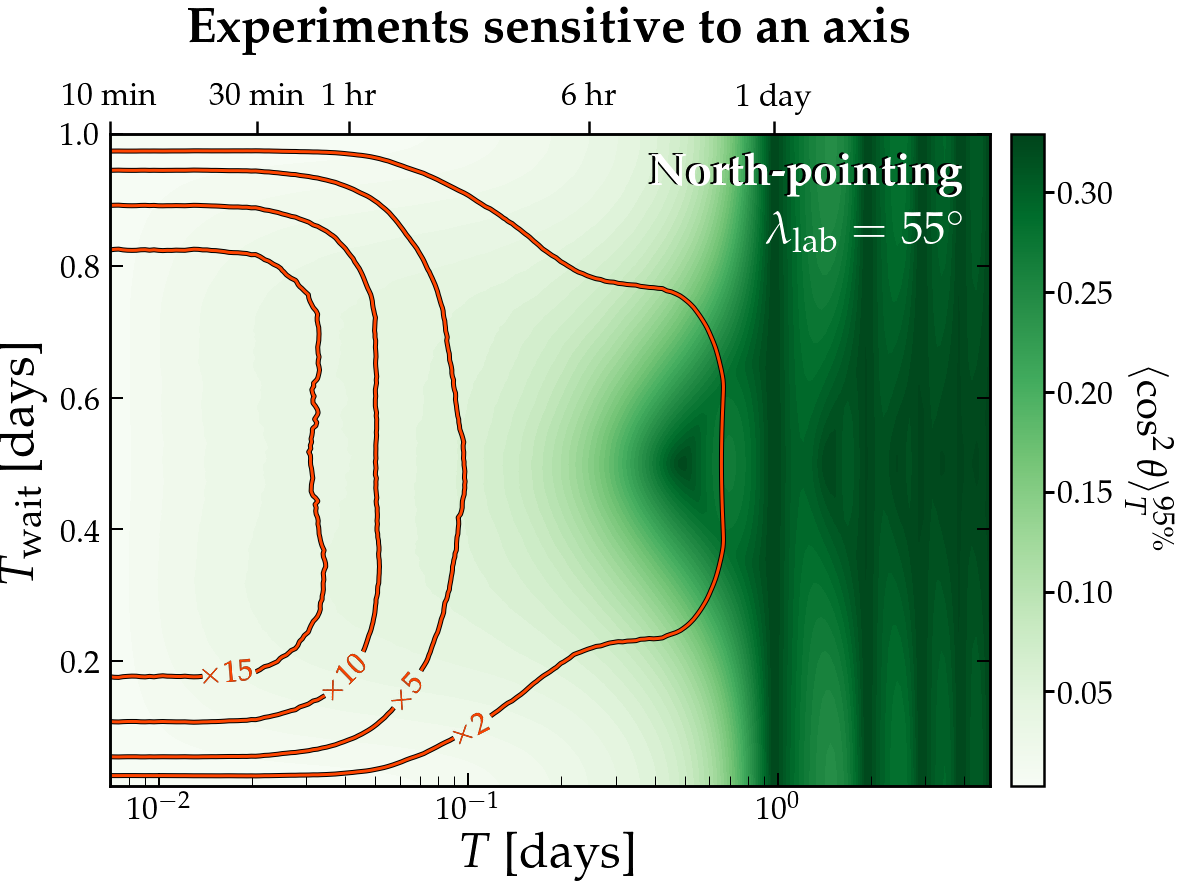

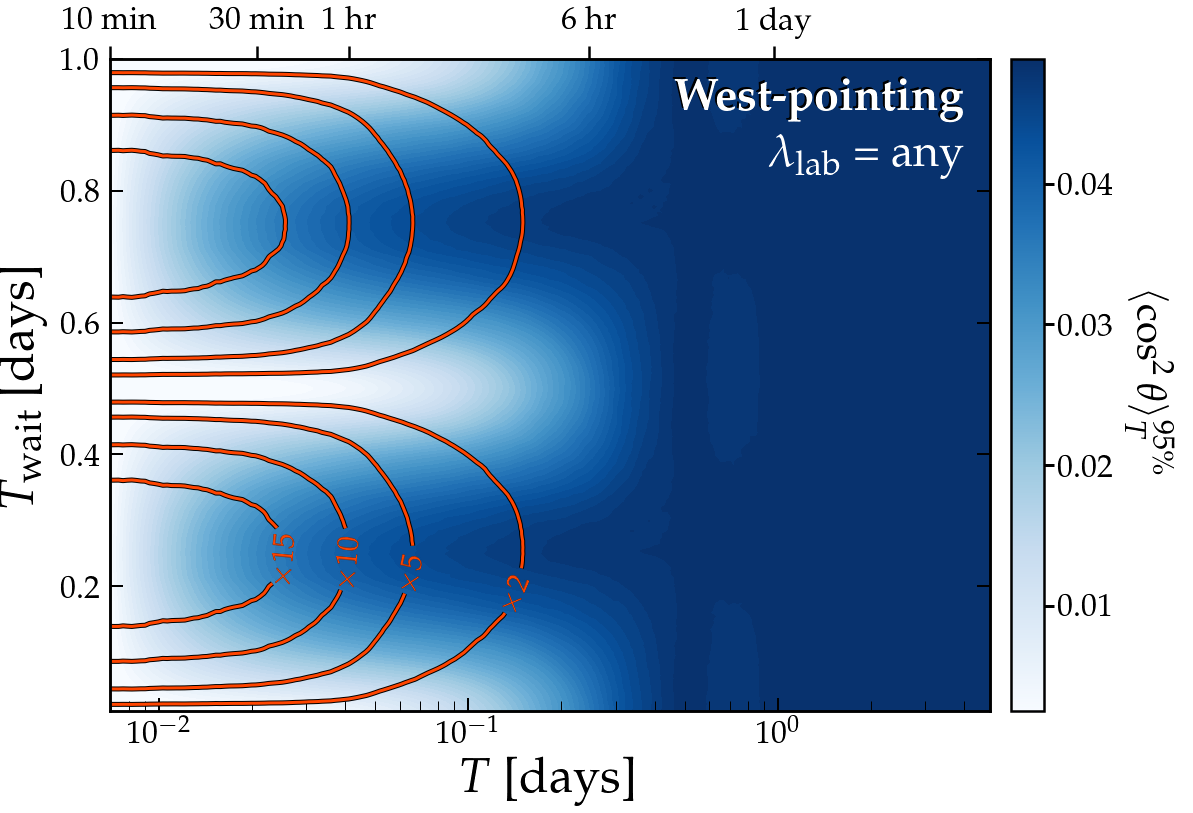

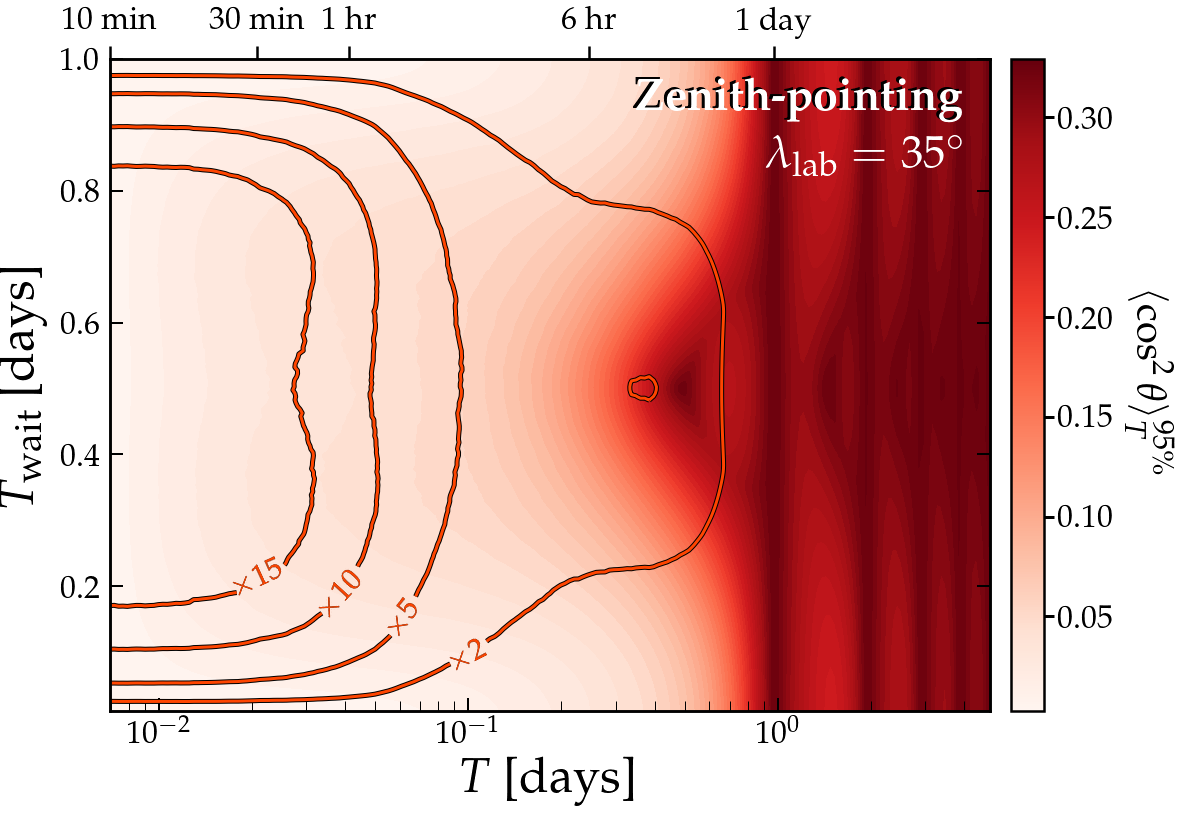

In [7]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe
pek=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$\times${s}"

def Plot_costh_Rescan(C,C_enhancement,levels,clab_loc,cmap,cont_col,axis_lab,lat_lab,cbar_lab):
    fig,ax = MySquarePlot(r'$T$ [days]',r'$T_{\rm wait}$ [days]',size_x=19,tfs=32,lfs=49)
    ax.tick_params(pad=10)
    
    ax.set_xscale('log')
    ax.set_xlim([dTvals[0],dTvals[-2]])
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ax2.set_xlim([dTvals[0],dTvals[-1]])
    ax2.set_xticks([10/(24*60),30/(24*60),1/24,6/24,1])
    ax2.set_xticklabels(['10 min','30 min','1 hr','6 hr','1 day'])
    ax2.minorticks_off()
    ax2.tick_params(which='major',direction='out',width=2.5,length=13,pad=7)

    plt.sca(ax)
    im = ax.pcolormesh(dTvals[0:-1],DTvals,C,cmap=cmap,vmin=0.0025,vmax=amax(C),rasterized=True)
    ax.contourf(dTvals[0:-1],DTvals,C,cmap=cmap,levels=50,vmin=0.0025,vmax=amax(C))
    CS1 = ax.contour(dTvals[0:-1],DTvals,C_enhancement,levels=levels,colors=['k'],linewidths=5)
    CS = ax.contour(dTvals[0:-1],DTvals,C_enhancement,levels=levels,colors=[cont_col],linewidths=3)
    plt.plot([],[],'-',color=cont_col,lw=3,label='Enhancement',path_effects=pek)
    ax.clabel(CS1, CS1.levels, inline=True, fmt=fmt,fontsize=30,manual=clab_loc)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=30,manual=clab_loc)

    #plt.legend(framealpha=1,loc='lower right')
    cbar1 = plt.colorbar(im,pad=0.02)
    cbar1.ax.tick_params(which='minor',length=8,width=2)
    cbar1.ax.tick_params(which='major',length=10,width=3)
    cbar1.set_label(cbar_lab,fontsize=40,rotation=-90,labelpad=50)

    plt.gcf().text(0.748,0.822,axis_lab,fontsize=45,ha='right',color='k')
    plt.gcf().text(0.75,0.82,axis_lab,fontsize=45,ha='right',color='w')
    plt.gcf().text(0.75,0.745,lat_lab,fontsize=45,ha='right',color='w')
    plt.gcf().text(0.9,0.5,'--',zorder=-100,color='w')
    return fig,ax

cbar_lab = r'$\langle \cos^2\theta \rangle_T^{95\%}$'

levels1 = [2,5,10,15]
clab_loc1 = [(0.016, 0.32), (0.035, 0.21), (0.06, 0.17), (0.11, 0.07)]
axis_lab1 = r'{\bf North-pointing}'
lat_lab1 = r'$\lambda_{\rm lab} = '+str(int(55))+r'^\circ$'

levels2 = [2,5,10,15]
clab_loc2 = [(0.022, 0.25), (0.04, 0.24), (0.07, 0.22), (0.2, 0.16)]
axis_lab2 = r'{\bf West-pointing}'
lat_lab2 = r'$\lambda_{\rm lab}$ = {\rm any}'

levels3 = [2,5,10,15]
clab_loc3 = [(0.0175, 0.31), (0.035, 0.21), (0.07, 0.13), (0.1, 0.1)]
axis_lab3 = r'{\bf Zenith-pointing}'
lat_lab3 = r'$\lambda_{\rm lab} = '+str(int(35))+r'^\circ$'

fig1,ax1 = Plot_costh_Rescan(CN,CN_enhancement,levels1,clab_loc1,cm.Greens,'orangered',axis_lab1,lat_lab1,cbar_lab)
plt.title(r'{\bf Experiments sensitive to an axis}',fontsize=50,pad=40)

fig2,ax2 = Plot_costh_Rescan(CW,CW_enhancement,levels2,clab_loc2,cm.Blues,'orangered',axis_lab2,lat_lab2,cbar_lab)
fig3,ax3 = Plot_costh_Rescan(CZ,CZ_enhancement,levels3,clab_loc3,cm.Reds,'orangered',axis_lab3,lat_lab3,cbar_lab)

MySaveFig(fig1,'Rescan_North')
MySaveFig(fig2,'Rescan_West')
MySaveFig(fig3,'Rescan_Zenith')

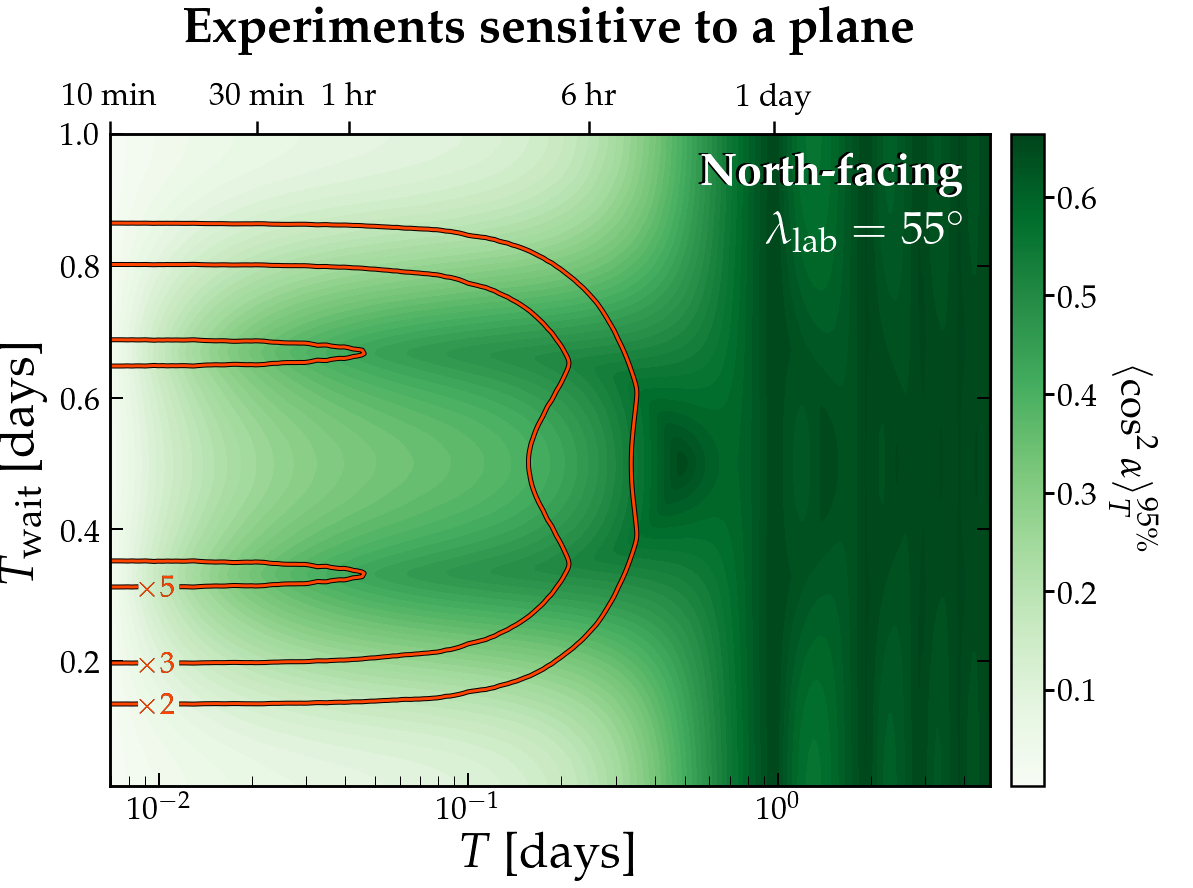

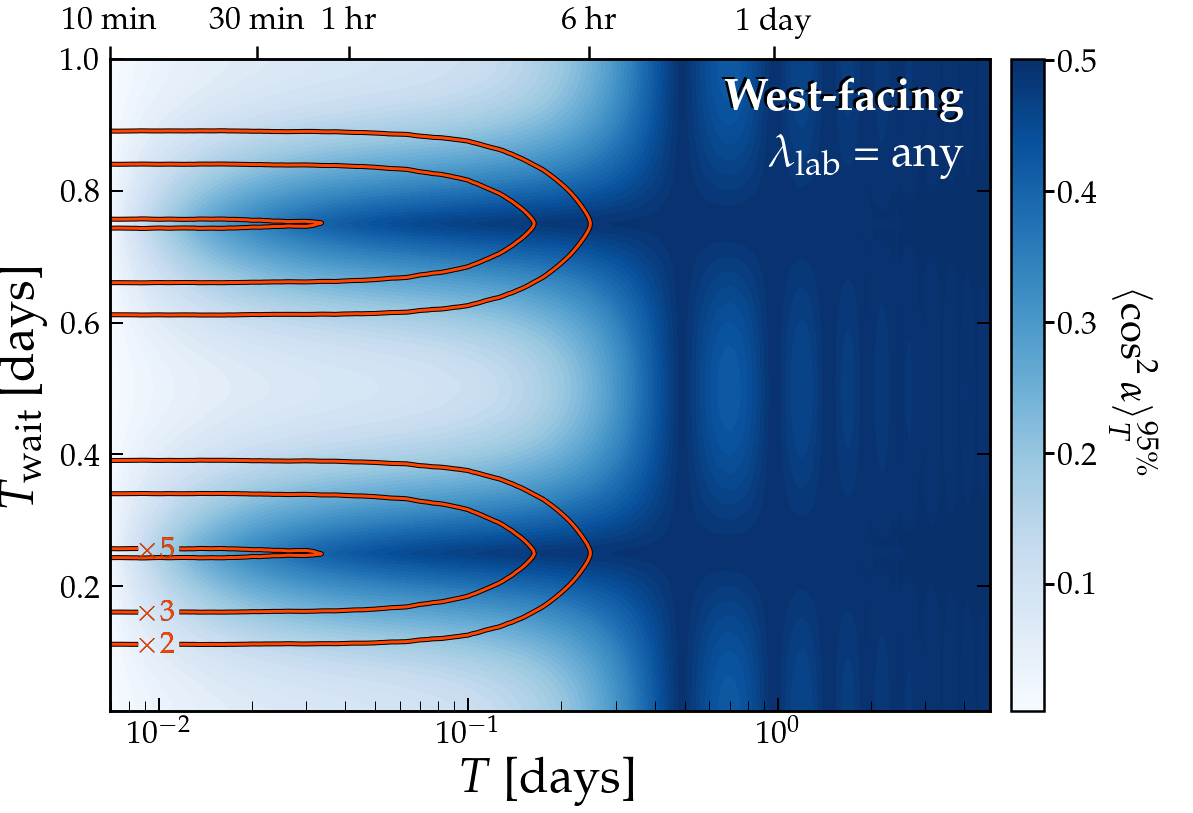

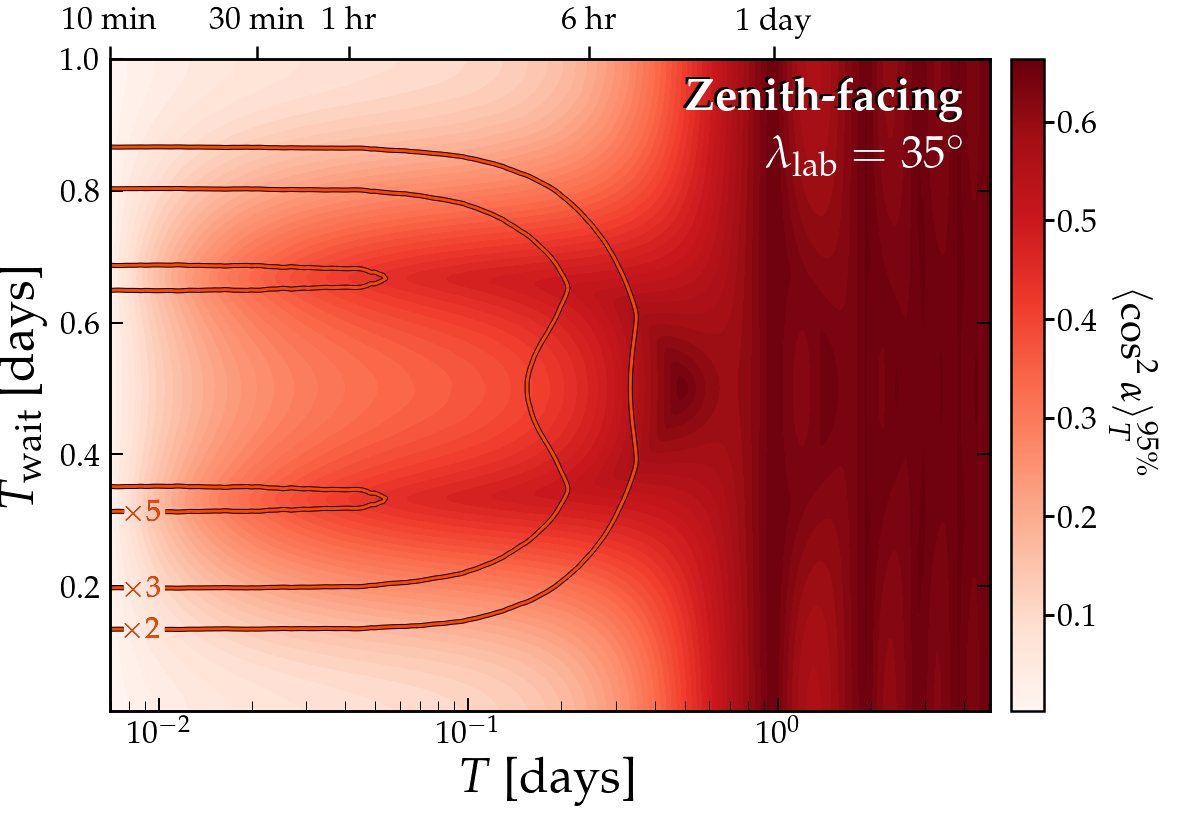

In [8]:
cbar_lab = r'$\langle \cos^2\alpha \rangle_T^{95\%}$'


levels1 = [2,3,5]
clab_loc1 = [(0.01, 0.32), (0.01, 0.18), (0.01, 0.1)]
axis_lab1 = r'{\bf North-facing}'
lat_lab1 = r'$\lambda_{\rm lab} = '+str(int(55))+r'^\circ$'

levels2 = [2,3,5]
clab_loc2 = [(0.01, 0.25), (0.01, 0.18), (0.01, 0.1)]
axis_lab2 = r'{\bf West-facing}'
lat_lab2 = r'$\lambda_{\rm lab}$ = {\rm any}'

levels3 = [2,3,5]
clab_loc3 = [(0.009, 0.32), (0.009, 0.18), (0.009, 0.1)]
axis_lab3 = r'{\bf Zenith-facing}'
lat_lab3 = r'$\lambda_{\rm lab} = '+str(int(35))+r'^\circ$'


fig1,ax1 = Plot_costh_Rescan(CZW,CZW_enhancement,levels1,clab_loc1,cm.Greens,'orangered',axis_lab1,lat_lab1,cbar_lab)
plt.title(r'{\bf Experiments sensitive to a plane}',fontsize=50,pad=40)

fig2,ax2 = Plot_costh_Rescan(CZN,CZN_enhancement,levels2,clab_loc2,cm.Blues,'orangered',axis_lab2,lat_lab2,cbar_lab)
fig3,ax3 = Plot_costh_Rescan(CNW,CNW_enhancement,levels3,clab_loc3,cm.Reds,'orangered',axis_lab3,lat_lab3,cbar_lab)

MySaveFig(fig1,'Rescan_NorthFacing')
MySaveFig(fig2,'Rescan_WestFacing')
MySaveFig(fig3,'Rescan_ZenithFacing')